In [42]:
import os
import cv2
import skimage

import numpy as np
import sklearn
import pandas as pd  
import tensorflow as tf

from keras.models import load_model
from mtcnn import MTCNN
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import inspect 

import mpld3


In [46]:
from face_embedding import face_embedding
from face_detection import face_cropping, l2_normalize
from save_file import save_data

In [47]:
import face_detection
from importlib import reload
reload(face_detection)

<module 'face_detection' from '/Users/aro/Dev/gitlab-fr-metric/face-reco-metrics/notebooks/face_detection.py'>

In [3]:
sklearn.__version__

'1.3.0'

In [4]:
# build a dictionary to link repository of the gallery and person ID
# the name of the repository is the celebrity name
gallery_path = '../data/galleries/'

person_paths = {}
for name in os.listdir(gallery_path):
    dir_name = os.path.join(gallery_path, name)
    if os.path.isdir(dir_name):
        person_paths[name] =  dir_name
person_paths

{'Q295093': '../data/galleries/Q295093',
 'Q933434': '../data/galleries/Q933434',
 'Q1210514': '../data/galleries/Q1210514'}

In [29]:
# load the DNN to generate the embeddings
# from deep face 
#model_path = '../data/models/deepface/keras/deepface_fn_512.h5'
model_path = '../data/models/deepface/keras/deepface_fn_128.h5'

# from face net
#model_path = '../data/models/facenet/keras/facenet_ds_keras_128.h5'
#model_path = '../data/models/facenet/keras/facenet_ds_keras_512.h5'

model_emb = load_model(model_path, compile = False , custom_objects={"tf": tf})


/Users/aro/virtualenvs/benchmark-face-reco-YqF_etr5/lib/python3.9/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: DeepFace is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [30]:
# Save files : crop faces and metadata
path_arrays = "../data/embeddings/"

# metadata from the dataset
# files_id                              7b50733819894f0e96756b79e9ef93df
# video_title          Claude Lelouch et Didier Barbelivien : ils ont...
# video_url                  https://www.youtube.com/watch?v=lwfKc4HuuCk
# program_name                                         Vivement Dimanche
# all_personalities                   ['Q933434', 'Q295093', 'Q1210514']
# video_length                                              00:01:42.000

array_name = "celebrities_7b50733819894f0e96756b79e9ef93df"
file_emb_celeb_np = path_arrays + array_name
file_metadata_json = path_arrays + array_name

# Hyperparamters for cropping
margin = 0 # Contour margin for the face cropping
# croping ratio =  size of the image / size of the face croped
min_crop_ratio = 0.05  # minimum value for the croping ratio
image_size = 160  # after resizing to compute to embeddings
min_face_size = 120  # in the face detection process
metadata_celeb = {
    'filename_metadata': file_metadata_json + '.json',
    'filename_embeddings': file_emb_celeb_np + '.npz',
    'face_detection': 'MTCNN',
    'model_emb': 'facenet_ds_keras_512.h5',
    'persons': ['Q933434', 'Q295093', 'Q1210514'],
    'crop_margin': margin,
    'min_face_size': min_face_size,
    'min_crop_ratio': min_crop_ratio,
    'image_size': image_size,
}

In [31]:
# MTCNN model
face_detector = MTCNN(min_face_size=min_face_size)

# faces
faces_embeddings = {}

for person_id, person_path in person_paths.items():

    for file_name in os.listdir(person_path):

        file_name_path = person_path + '/' + file_name
        image_np = cv2.cvtColor(cv2.imread(file_name_path), cv2.COLOR_BGR2RGB)

        face_crop = face_cropping(image_np, face_detector,
                                  margin=margin,
                                  image_size=image_size,
                                  flag_normalise=False,
                                  min_crop_ratio = min_crop_ratio,
                                  flag_plot=True)
        if face_crop.size > 0:
            face_emb = face_embedding(model_emb, face_crop)
            faces_embeddings[file_name] = face_emb[0] # the output is a list to manage chunks

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


In [32]:
faces_emb_celeb_np = np.array(list(faces_embeddings.values()))
labels = list(faces_embeddings.keys())

# instantiate the tsne 
tsne = TSNE(n_iter=1500, n_components=2, perplexity=10)
# fit
embs_tsne = tsne.fit_transform(faces_emb_celeb_np)

# Visualisation of the embeddings space 

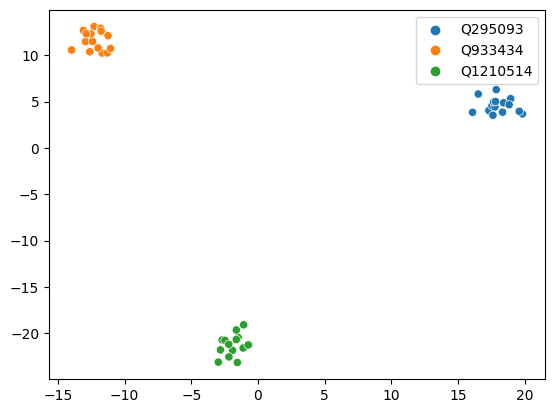

In [33]:

label_legend = [ label.split('.')[0].split('_')[0] for label in labels ]

mpld3.enable_notebook()

x = embs_tsne[:, 0]
y = embs_tsne[:, 1]

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=label_legend)
plt.show()

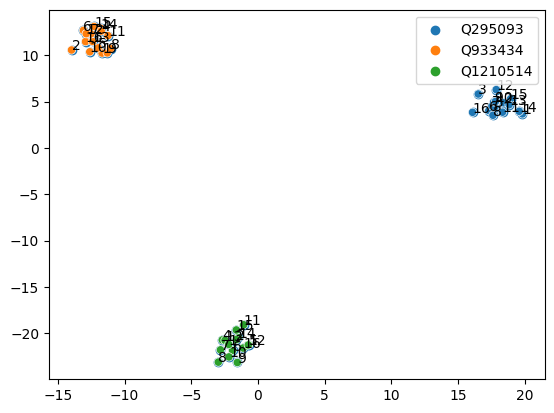

In [34]:
# visualise the inndex of the gallery : usefull when there is an overlap
# i.e bad quality embeddings

label_annot = [ label.split('.')[0].split('_')[1] for label in labels ]

fig, ax = plt.subplots()
ax.scatter(x, y)

p1 = sns.scatterplot(x=x, y=y, hue=label_legend)
for i, txt in enumerate(label_annot):
    p1.annotate(txt, (x[i], y[i]))
plt.show()

In [35]:
label_save = np.array([ label.split('.')[0].split('_')[0] for label in labels ])
save_dict = {}
save_dict['embeddings'] = faces_emb_celeb_np
save_dict['person_id'] = label_save
save_dict

{'embeddings': array([[ 2.1955025 ,  0.1448631 , -0.7939366 , ..., -1.499771  ,
          0.14771934, -1.1660727 ],
        [ 2.2509303 , -0.0392784 , -0.94439423, ..., -0.6153582 ,
         -0.5006935 , -0.618657  ],
        [ 2.3362556 ,  0.6282723 , -0.8132154 , ..., -1.4413036 ,
         -0.38002422, -1.8734499 ],
        ...,
        [ 0.59276855, -1.2256871 , -0.02813148, ...,  1.8889784 ,
         -0.30505094, -1.1613296 ],
        [-0.9501208 , -0.9668473 , -1.9101537 , ..., -0.20190269,
         -0.3609612 , -0.43286917],
        [ 0.39839438, -1.5507413 , -1.3036932 , ..., -0.16245605,
         -0.61284566, -0.07775269]], dtype=float32),
 'person_id': array(['Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
        'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
        'Q295093', 'Q295093', 'Q295093', 'Q933434', 'Q933434', 'Q933434',
        'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434',
        'Q933434', 'Q933434', 'Q933

In [36]:
save_data(file_emb_celeb_np, save_dict, file_metadata_json, metadata_celeb)

In [37]:
#load embeddings
file_name = file_emb_celeb_np + '.npz'
a = np.load(file_name)

In [38]:
a['embeddings']

array([[ 2.1955025 ,  0.1448631 , -0.7939366 , ..., -1.499771  ,
         0.14771934, -1.1660727 ],
       [ 2.2509303 , -0.0392784 , -0.94439423, ..., -0.6153582 ,
        -0.5006935 , -0.618657  ],
       [ 2.3362556 ,  0.6282723 , -0.8132154 , ..., -1.4413036 ,
        -0.38002422, -1.8734499 ],
       ...,
       [ 0.59276855, -1.2256871 , -0.02813148, ...,  1.8889784 ,
        -0.30505094, -1.1613296 ],
       [-0.9501208 , -0.9668473 , -1.9101537 , ..., -0.20190269,
        -0.3609612 , -0.43286917],
       [ 0.39839438, -1.5507413 , -1.3036932 , ..., -0.16245605,
        -0.61284566, -0.07775269]], dtype=float32)

In [39]:
a['person_id']

array(['Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
       'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
       'Q295093', 'Q295093', 'Q295093', 'Q933434', 'Q933434', 'Q933434',
       'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434',
       'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434',
       'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514',
       'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514',
       'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514'],
      dtype='<U8')